In this notebook we present some basic application of random forest to
the parameterization of the L96 model previously introduced.

In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import sklearn
import L96_model_XYtend
from L96_model_XYtend import EulerFwd, RK2, RK4
from L96_model_XYtend import L96, L96_eq1_xdot, integrate_L96_2t

In [2]:
# Main script parameters
K=8
J=32
FORCING=18
dt=0.05
T_SPINUP=20


In [3]:
model = L96_model_XYtend.L96(K, J, F=FORCING)
# First run for spin up
model.run(dt, T_SPINUP, store=True)
# The data from the run below will be used both for offline training and testing
X_history, Y_history, t, closure = model.run(0.05, 30., store=True)

In [4]:
mean_X = X_history.mean(axis=0)
std_X = X_history.std(axis=0)
mean_X, std_X

(array([3.56001459, 3.43503864, 3.49270022, 3.87408476, 3.53354247,
        3.50219397, 3.51712616, 3.86076854]),
 array([4.61758395, 4.65072023, 4.33667296, 4.71210126, 4.55304913,
        4.46010283, 4.1892557 , 4.66729955]))

<IPython.core.display.Javascript object>


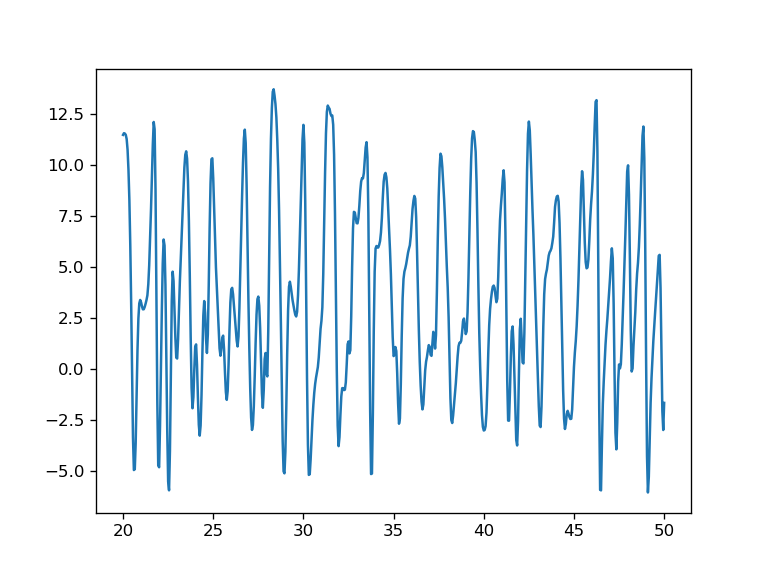

In [5]:
plt.figure()
plt.plot(t, X_history[:, 0])

In [6]:
closure.shape

(601, 8)

<IPython.core.display.Javascript object>


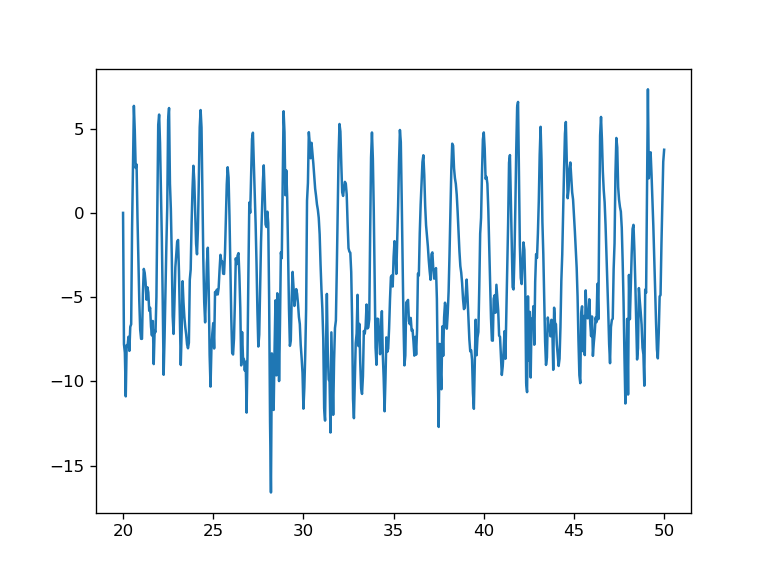

In [7]:
plt.figure()
plt.plot(t, closure[:, 0])

Scatter-plot of closure vs large-scale state X

<IPython.core.display.Javascript object>


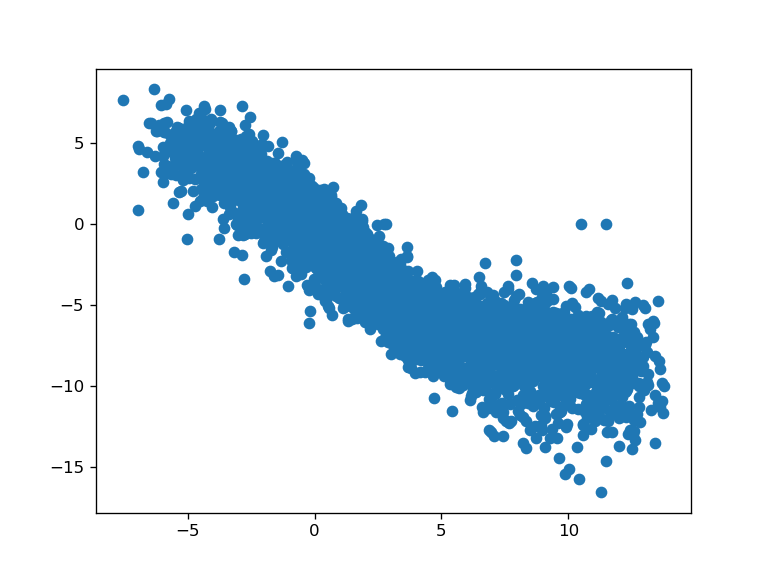

In [8]:
plt.figure()
plt.scatter(X_history.flatten(), closure.flatten())

## Starting with a single classification tree

We start with a very simple approach: we use a single value of the state as our feature (i.e. our feature is
one-dimensional).

### Offline training / fitting and testing

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
closure.shape, X_history.shape

((601, 8), (601, 8))

First we split the data into training and test

In [11]:
X_train, X_test, xy_train, xy_test = train_test_split(X_history.flatten().reshape(-1, 1), closure.flatten(), test_size=0.33)

Then we define our decision tree. For the sake of the example, we limit the number of leaves to 5. Feel free to increase that number and see how the plot below, showing the true and fitted data, changes. In particular, for larger values, we can see that we overfit the data.

In [12]:
from sklearn import tree
single_tree = tree.DecisionTreeRegressor(max_leaf_nodes=5)
single_tree.fit(X_train, xy_train)

DecisionTreeRegressor(max_leaf_nodes=5)

Here we plot the true training data (the large scale state values on the x-axis, and the parameterization value on the y-axis) and the fitted data.

<IPython.core.display.Javascript object>


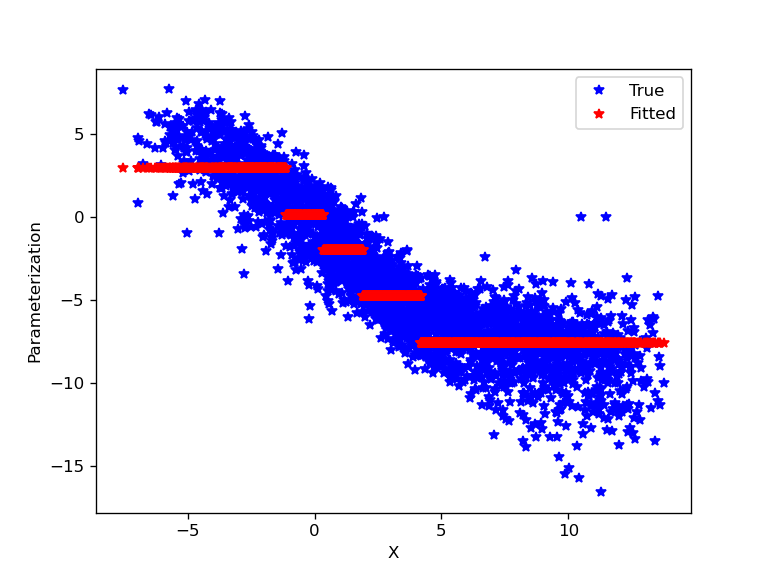

In [13]:
plt.figure()
plt.plot(X_train, xy_train, 'b*')
plt.plot(X_train, single_tree.predict(X_train), 'r*')
plt.xlabel('X')
plt.ylabel('Parameterization')
plt.legend(('True', 'Fitted'))

Now, same plot but for the test data. The test data has not been seen during the fitting procedure, so in some sense this is the true test. While we may fit very well the training data, overfitting will result in poor performance on the test dataset.

<IPython.core.display.Javascript object>


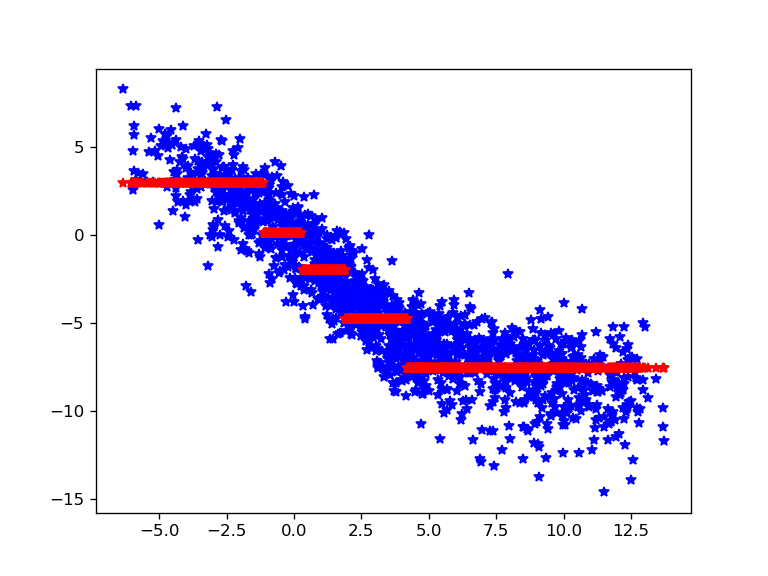

In [14]:
plt.figure()
plt.plot(X_test, xy_test, 'b*')
plt.plot(X_test, single_tree.predict(X_test), 'r*')

<IPython.core.display.Javascript object>


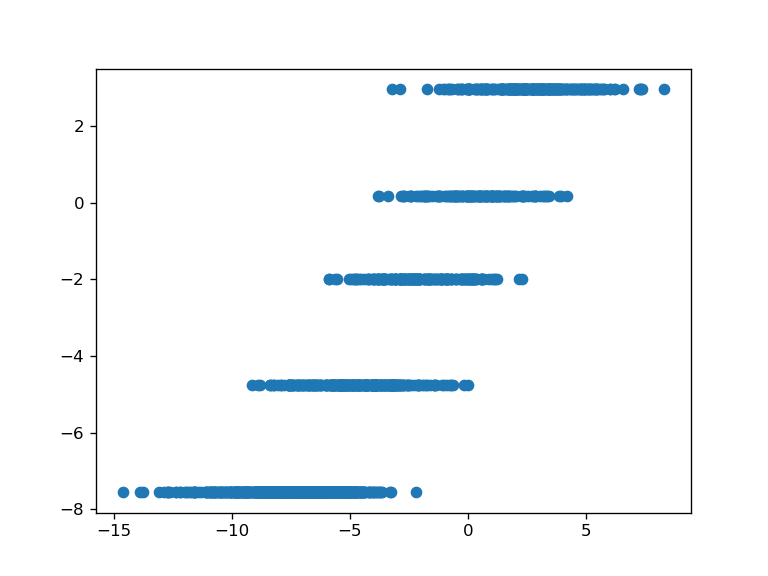

In [15]:
plt.figure()
plt.scatter(xy_test, single_tree.predict(X_test))

In [16]:
fit_score = single_tree.score(X_train, xy_train)
test_score = single_tree.score(X_test, xy_test)
print(fit_score, test_score)

0.8236261198668515 0.8165381374334532


To understand overfitting, we will increase the number of leaves up to 500, and store the fit loss and test loss for plotting

In [17]:
nb_leaves = list(map(lambda x: int(np.exp(x / 2)) + 1, range(1, 13)))

<IPython.core.display.Javascript object>


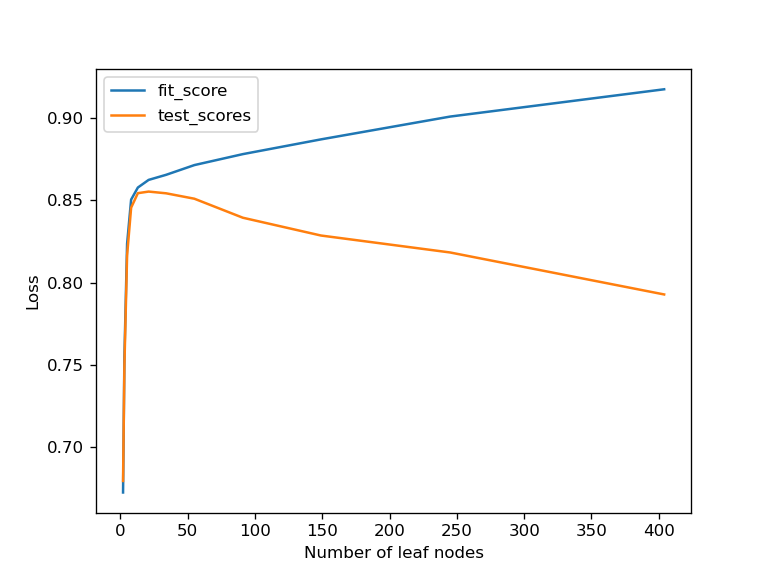

Text(0, 0.5, 'Loss')

In [18]:
fit_scores, test_scores = [], []
for nb in nb_leaves:
    current_tree = tree.DecisionTreeRegressor(max_leaf_nodes=nb)
    current_tree.fit(X_train, xy_train)
    fit_scores.append(current_tree.score(X_train, xy_train))
    test_scores.append(current_tree.score(X_test, xy_test))

plt.figure()
plt.plot(nb_leaves, list(fit_scores))
plt.plot(nb_leaves, list(test_scores))
plt.legend(('fit_score', 'test_scores'))
plt.xlabel('Number of leaf nodes')
plt.ylabel('Loss')

### Online implementation of the parameterization

Now let's implement this as a parameterization for L96.

In [19]:
class Parameterization:
    def __init__(self, predictor):
        self.predictor = predictor

    def __call__(self, X):
        X = X.reshape(-1, 1)
        return self.predictor.predict(X)

Here we use the GCM class defined by Yani in his notebook

In [20]:
class GCM:
    def __init__(self, F, parameterization, time_stepping=RK4):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping
        
    def rhs(self,X):
        return L96_eq1_xdot(X, self.F) +  self.parameterization(X)
        
    def __call__(self,X0, dt, nt):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [21]:
gcm = GCM(model.F, Parameterization(single_tree))
gcm_no_param = GCM(model.F, lambda x: 0)

In [22]:
n_steps = 6000

In [23]:
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


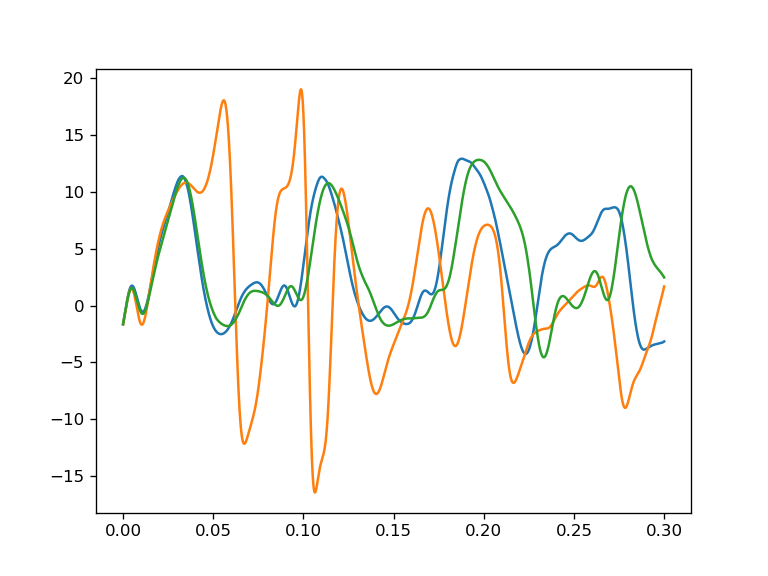

In [24]:
plt.figure()
plt.plot(t * dt, X_true[:, 0])
plt.plot(t * dt, X_no_param[:, 0])
plt.plot(t * dt, X_param[:, 0])

<IPython.core.display.Javascript object>


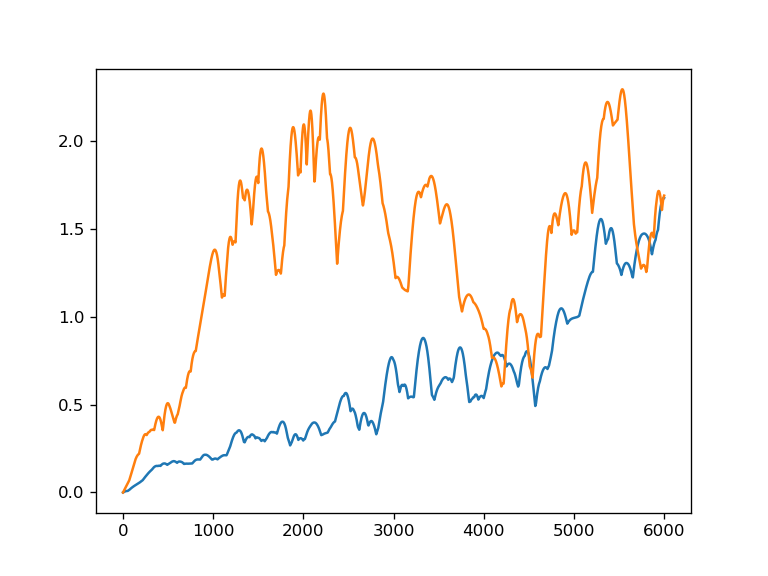

In [25]:
plt.figure()
plt.plot(abs(X_param - X_true).sum(axis=-1) / std_X.sum())
plt.plot(abs(X_no_param - X_true).sum(axis=-1) / std_X.sum())

## Multiple features

In this section, we use the global state.

In [26]:
single_tree = tree.DecisionTreeRegressor(max_leaf_nodes=10)

In [27]:
X_train, X_test, xy_train, xy_test = train_test_split(X_history, closure[:, 0], test_size=0.33)

In [28]:
single_tree.fit(X_train, xy_train)

DecisionTreeRegressor(max_leaf_nodes=10)

In [29]:
single_tree.score(X_train, xy_train)

0.8717711291232538

In [30]:
single_tree.score(X_test, xy_test)

0.8415049858655241

We need to adapt our parameterization so that it makes use of the homogeneity of the problem

In [31]:
class Parameterization:
    def __init__(self, predictor):
        self.predictor = predictor

    def __call__(self, X):
        X = X.reshape(1, K)
        new_X = []
        for i in range(K):
            new_X.append(np.roll(X, -i, axis=-1))
        new_X = np.concatenate(new_X, 0)
        return self.predictor.predict(new_X)

In [32]:
gcm = GCM(model.F, Parameterization(single_tree))
gcm_no_param = GCM(model.F, lambda x: 0)

In [33]:
n_steps = 6000

In [34]:
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


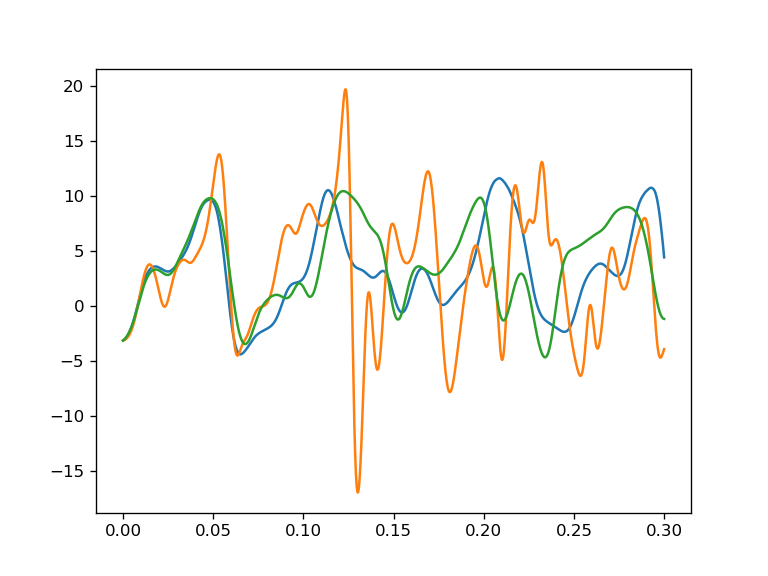

In [35]:
plt.figure()
plt.plot(t * dt, X_true[:, 0])
plt.plot(t * dt, X_no_param[:, 0])
plt.plot(t * dt, X_param[:, 0])

## Random Forest: ensemble of decision trees

Here we use a random forest instead of a single decision tree. The idea is simple: to avoid overfitting, one trains several decision trees on the same data.  The prediction of the random forest is then the average prediction of all decision trees within the ensemble.

There are two main ways in which the fitted trees within the forest might differ:
- the selected features for the splits: at each iteration of the fitting procedure, the algorithm does not consider all features to select the best split, at least not when the number of features is large. Instead, a finite number of features is considered at random. 
- the data on which they are trained. Below, by setting bootstrap to True and max_samples to 0.5, we specify that each tree within the forest will only be trained on half of the training data

In [36]:
from sklearn.ensemble import RandomForestRegressor

In [37]:
# We start with an ensemble of 10 decision trees
rf = RandomForestRegressor(n_estimators=20, max_leaf_nodes=30, bootstrap=True, max_samples=0.5)

Same thing, we fit to the training data, and test on the test data

In [38]:
rf.max_features

'auto'

In [39]:
rf.fit(X_train, xy_train)

RandomForestRegressor(max_leaf_nodes=30, max_samples=0.5, n_estimators=20)

We can actually get the prediction of each tree within the forest:

In [40]:
tree_predictions = []
for est in rf.estimators_:
    tree_predictions.append(est.predict(X_test[:1, :]))
tree_predictions = np.array(tree_predictions)
print(tree_predictions)
print(tree_predictions.mean())
print(rf.predict(X_test[:1, :])[0])

[[6.54783721]
 [4.63020739]
 [5.55468038]
 [3.64404818]
 [3.34077564]
 [3.55444201]
 [4.55841604]
 [5.52959489]
 [2.84403495]
 [3.24719032]
 [2.08286945]
 [5.26411095]
 [5.37436627]
 [2.81621441]
 [4.18011316]
 [2.24818069]
 [5.90444101]
 [3.02345883]
 [4.04909149]
 [3.62186703]]
4.100797015732321
4.10079701573232


In [41]:
rf.score(X_train, xy_train)

0.9282874271897419

In [42]:
rf.score(X_test, xy_test)

0.8744776024061957

Again, we can test this online.

In [43]:
gcm = GCM(model.F, Parameterization(rf))
gcm_no_param = GCM(model.F, lambda x: 0)

In [44]:
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


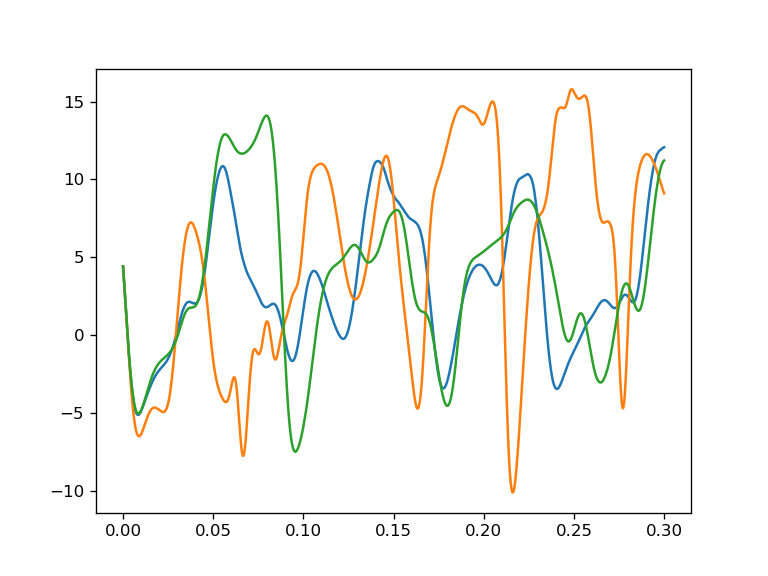

In [45]:
plt.figure()
plt.plot(t * dt, X_true[:, 0])
plt.plot(t * dt, X_no_param[:, 0])
plt.plot(t * dt, X_param[:, 0])

## More features: using past state

Here we further increase the complexity of our approach by incorporating past state into the features used to carry out our prediction.

In [46]:
n_times = 3

In [47]:
X_history.shape

(601, 8)

In [48]:
closure.shape

(601, 8)

In [49]:
new_X = X_history.copy()
for i in range(n_times - 1):
    new_X = np.concatenate((new_X, np.roll(X_history, i + 1, axis=0)), axis=1)
new_X = new_X[n_times:]
new_closure = closure[n_times:]

In [50]:
new_X.shape

(598, 24)

In [51]:
new_X[:3]

array([[11.49445095,  1.67740942,  3.14535424,  6.96561443,  7.08313968,
        -3.88555022,  1.58818248,  3.01146188, 11.55697431,  0.39806378,
         2.9178782 ,  5.67744348,  8.94101867, -2.88730533, -0.21814892,
         1.85086952, 11.57668465, -1.05099282,  2.1384603 ,  4.04167691,
        10.07518789, -1.05119466, -1.99133967,  1.9443873 ],
       [11.28892211,  1.88830737,  3.18638163,  7.77682587,  4.69572998,
        -4.0498408 ,  2.62042845,  5.14468032, 11.49445095,  1.67740942,
         3.14535424,  6.96561443,  7.08313968, -3.88555022,  1.58818248,
         3.01146188, 11.55697431,  0.39806378,  2.9178782 ,  5.67744348,
         8.94101867, -2.88730533, -0.21814892,  1.85086952],
       [10.7694493 ,  0.84086274,  3.32259017,  8.24448323,  2.27791486,
        -3.74253882,  2.60869684,  7.35549244, 11.28892211,  1.88830737,
         3.18638163,  7.77682587,  4.69572998, -4.0498408 ,  2.62042845,
         5.14468032, 11.49445095,  1.67740942,  3.14535424,  6.96561443,
  

In [52]:
X_train, X_test, xy_train, xy_test = train_test_split(new_X, new_closure[:, 0], test_size=0.33)

In [53]:
X_train.shape

(400, 24)

In [54]:
rf.fit(X_train, xy_train)

RandomForestRegressor(max_leaf_nodes=30, max_samples=0.5, n_estimators=20)

In [55]:
rf.score(X_train, xy_train)

0.9517854376583118

In [56]:
rf.score(X_test, xy_test)

0.902841869923894

Again we need to adapt the form of the parameterization, here so that it records past values of the state for later use.

In [57]:
from collections import deque
class Parameterization:
    def __init__(self, predictor, n_times: int):
        self.predictor = predictor
        self.past_states = deque(maxlen=n_times)
        self.n_times = n_times

    def __call__(self, X):
        X = X.reshape(1, K)
        new_X = []
        for i in range(K):
            new_X.append(np.roll(X, -i, axis=-1))
        new_X = np.concatenate(new_X, 0)
        shape = new_X.shape
        save_X = new_X.copy()
        for i in range(self.n_times - 1):
            try:
                new_X = np.concatenate((new_X, self.past_states[i]), axis=1)
            except IndexError:
                new_X = np.concatenate((new_X, np.zeros(shape)), axis=1)
        self.past_states.append(save_X)
        return self.predictor.predict(new_X)

In [58]:
gcm = GCM(model.F, Parameterization(rf, n_times))
gcm_no_param = GCM(model.F, lambda x: 0)
X_param, t = gcm(model.X, model.dt, n_steps)
X_no_param, t = gcm_no_param(model.X, model.dt, n_steps)
X_true, _, _, _ = model.run(model.dt, n_steps * model.dt, store=True)

<IPython.core.display.Javascript object>


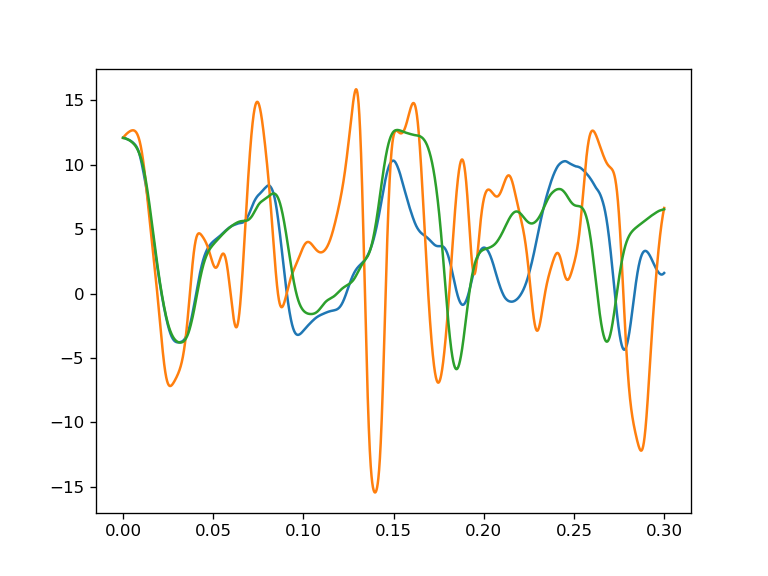

In [59]:
plt.figure()
plt.plot(t * dt, X_true[:, 0])
plt.plot(t * dt, X_no_param[:, 0])
plt.plot(t * dt, X_param[:, 0])